In [120]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pdflatex
import pylatexenc
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import importlib

import train
importlib.reload(train)
from train import train_DQN
from train import train_quantum_dqn


from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit.circuit import Parameter
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_aer import Aer
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Quick Check to see if my GPU is being detected
device = torch.device("cuda" if torch.cuda.is_available() else  "cpu")
print("Using ", device)
print(gym.__version__)

Using  cuda
0.26.1


# Classes used for Modelling

In [ ]:
# Defining a simple FF Network for cartpole
class Classical_DQN(nn.Module):
    def __init__ (self, state_size, action_size):
        super(Classical_DQN,self).__init__()

        self.layer_1 = nn.Linear(4, 256)
        self.layer_2 = nn.Linear(256,256)
        self.output  = nn.Linear(256, action_size)

    def forward(self, x):
        x = nn.functional.relu(self.layer_1(x))
        x = nn.functional.relu(self.layer_2(x))
        return self.output(x)
    




    

class Hybrid_DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(Hybrid_DQN,self).__init__()

        self.state_size = state_size
        self.action_size = action_size

        # Hybrid Net Structure
        self.quantum_layer     = self.create_quantum_layer()
        self.classical_layer_1 = nn.Linear(4, 256)
        self.classical_layer_2 = nn.Linear(256, 256)
        self.output_layer      = nn.Linear(256, action_size)


    def encode_cartpole_state(self, x):
        
        min_vals = torch.tensor([-4.8, -3.0, -0.418, -3.0], device=x.device)
        max_vals = torch.tensor([4.8, 3.0, 0.418, 3.0], device=x.device)

        theta_vals = (x - min_vals) / (max_vals - min_vals) * (2 * torch.pi) - torch.pi
        return theta_vals
    




    def forward(self, x):

        x = x.to(next(self.parameters()).device)
    
        # Encode the CartPole state and keep theta_vals on the same device as x
        theta_vals = self.encode_cartpole_state(x)


        x = self.quantum_layer(theta_vals)
        #x = torch.tensor([int(bit) for bit in f"{int(x.item()):04b}"])
        print("HUH",x)
        x = torch.relu(self.classical_layer_1(x))
        x = torch.relu(self.classical_layer_2(x))
        return self.output_layer(x)
    



    def create_quantum_layer(self):

        num_qubits = 4
        vqc = QuantumCircuit(num_qubits)

        # To transalte the state vector into a quantum representation
        encoding_params = [Parameter(f'theta_{i}') for i in range(num_qubits)]
        trainable_params = [Parameter(f'w_{i}') for i in range(num_qubits)]

        # Encoding
        for i, param in enumerate(encoding_params):
            vqc.ry(param, i)

        # Hadamard each qubit
        for i in range(num_qubits):
            vqc.h(i)

        # The Actual VQC
        for i, param in enumerate(trainable_params):
            vqc.ry(param, i)


        # Formating the output
        def interpret_measurement(measurement):

            bitstring = f"{measurement:04b}"
            # Convert the binary string to a list of integers
            binary_list = [int(bit) for bit in bitstring]
            #return f"{bin(measurement)}".count("1") % 2

            
            #return np.array(binary_list)
            print("jj",measurement)
            return measurement



        qnn = SamplerQNN(
            circuit=vqc,
            input_params=encoding_params,
            weight_params=trainable_params,
            interpret=interpret_measurement, # Like a real quantum measurement
            input_gradients=True,
            output_shape=4
        )
        return TorchConnector(qnn)

        

    
    

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)  # FIFO queue to hold experiences

    # Add an experience to the buffer
    def add(self, state, action, reward, next_state, done):
        
        self.buffer.append((state, action, reward, next_state, done))

    # Sample an experience from the buffer
    def sample(self, batch_size):

        return random.sample(self.buffer, batch_size)

    # Return the currenlength of the buffer
    def size(self):
        return len(self.buffer)

# Environment Setup

In [142]:
env = gym.make("CartPole-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Just for myself
#print("state space dim: %f", env.observation_space.shape[0])
#print("Action state size: %f", action_size)

# Creating live and target models
live_model = Classical_DQN(state_size, action_size).to(device)


target_model = Classical_DQN(state_size, action_size).to(device)
target_model.load_state_dict(live_model.state_dict())
target_model.eval()  

print(live_model)


# Creating live and target models
live_qmodel = Hybrid_DQN(state_size, action_size).to(device)
print(hasattr(live_qmodel, 'encode_cartpole_state'))

target_qmodel = Hybrid_DQN(state_size, action_size).to(device)
target_qmodel.load_state_dict(live_qmodel.state_dict())
target_qmodel.eval()  

print(live_qmodel)


print("Environment and models are set up.")

Classical_DQN(
  (layer_1): Linear(in_features=4, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=2, bias=True)
)
True
Hybrid_DQN(
  (quantum_layer): TorchConnector()
  (classical_layer_1): Linear(in_features=1, out_features=256, bias=True)
  (classical_layer_2): Linear(in_features=256, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=2, bias=True)
)
Environment and models are set up.


# Hyperparameter Tuning 

In [136]:

# Create the training buffer for experience replay
buffer_capacity = 10000
replay_buffer = ReplayBuffer(buffer_capacity)

optimizer = optim.Adam(live_model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

optimizerq = optim.Adam(live_qmodel.parameters(), lr=0.001)
criterionq = torch.nn.MSELoss()

gamma = 0.99              # Discount factor for future rewards
epsilon = 1.0             # Initial exploration rate
epsilon_decay = 0.99    # Decay rate for epsilon
epsilon_min = 0.005        # Minimum exploration rate
batch_size = 32          # Number of experiences sampled per update
target_update_freq = 10   # Frequency to update the target network
num_episodes = 100        # Total number of episodes to train

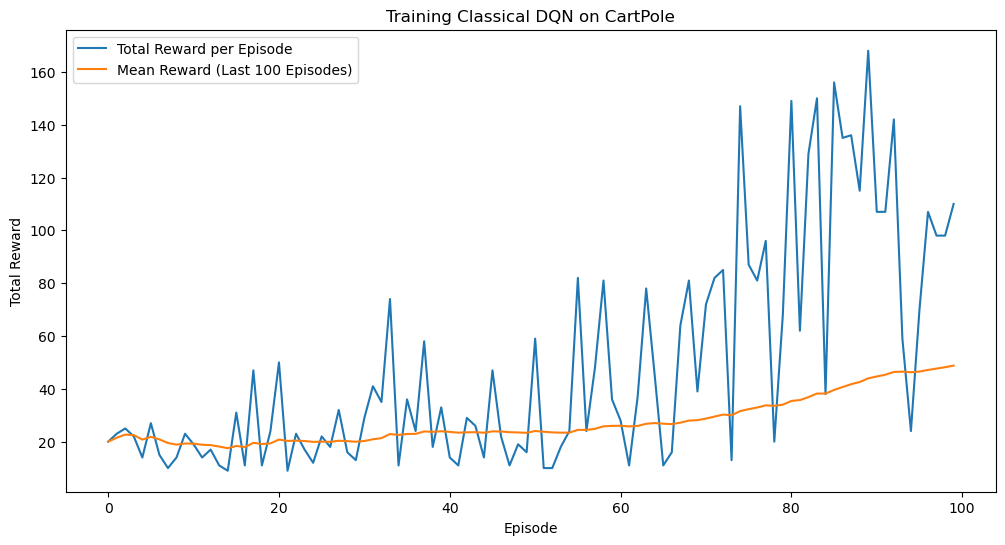

In [72]:
# Train the model
train_DQN(env, epsilon, epsilon_decay, num_episodes, replay_buffer, batch_size, target_update_freq, epsilon_min, gamma, device, live_model, target_model, criterion, optimizer)

In [143]:
#train_quantum_dqn(env, epsilon, epsilon_decay, num_episodes, replay_buffer, batch_size, target_update_freq, epsilon_min, gamma, device, live_qmodel, target_qmodel, criterion, optimizerq)

x = live_qmodel(torch.tensor([0.1,0.2,0.3,0.4]))
print("  YURRR",x)

jj 0
jj 1
jj 2
jj 3
jj 4
jj 5
jj 6
jj 7
jj 8
jj 9
jj 10
jj 11
jj 12
jj 13
jj 14
jj 15
HUH tensor([0.1567, 0.1459, 0.0427, 0.0398, 0.0134, 0.0124, 0.0036, 0.0034, 0.2183,
        0.2033, 0.0595, 0.0554, 0.0186, 0.0173, 0.0051, 0.0047, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0',
       grad_fn=<_TorchNNFunctionBackward>)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x32 and 1x256)